In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Importing modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json

from skimage.io import imread
from pathlib import Path
from tensorflow import keras

from config_GAN import *
from model_DISCRIMINATOR import Discriminator
from model_GENERATOR import Generator
from Augmentator import Aug
from data_generator import data_gen
from ConditionalGAN import ConditionalGAN
from CustomCallback import CustomCallback

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Preparing the dataset

In [4]:
# Define path to the data directory
data_dir = Path(path_to_data)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

# Forming Train, Val and Test

In [5]:
train_data = []  # The first collection for Train, Val, Test

### Path to Train
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

for img in normal_cases:
    train_data.append((img, 0, 0))  # The label for these cases will be 0

for img in pneumonia_cases:
    if 'bacteria' in str(img).lower():  # The label for these cases will be 1 if it's bacteria or 2 if it's viral
        train_data.append((img, 1, 0))
    else:
        train_data.append((img, 2, 0))

In [6]:
### Path to Val 
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

for img in normal_cases:
    train_data.append((img, 0, 0))  # The label for these cases will be 0

for img in pneumonia_cases:
    if 'bacteria' in str(img).lower():  # The label for these cases will be 1 if it's bacteria or 2 if it's viral
        train_data.append((img, 1, 0))
    else:
        train_data.append((img, 2, 0))

In [7]:
### Path to Train 
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

for img in normal_cases:
    train_data.append((img, 0, 0))  # The label for these cases will be 0

for img in pneumonia_cases:
    if 'bacteria' in str(img).lower():  # The label for these cases will be 1 if it's bacteria or 2 if it's viral
        train_data.append((img, 1, 0))
    else:
        train_data.append((img, 2, 0))

In [8]:
### Delete duplicate      
with open(path_to_duplicate, 'r') as F:
    check_list = json.load(F)

for i, j in check_list:
    for x, y, z in train_data:
        if i[i.rfind('/') + 1:] in str(x):
            index = train_data.index((x, y, z))
            train_data.pop(index)
            # deleted_files.append()

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label', 'add'], index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Divide into Train, Val and Test
test_data = train_data[:count_test]
valid_data = train_data[count_test: count_test + count_valid].reset_index(drop=True)
train_data = train_data[count_test + count_valid:].reset_index(drop=True)

train_data.head()

,image,label,add
0,chest-xray-pneumonia\chest_xray\train\PNEUMONI...,1,0
1,chest-xray-pneumonia\chest_xray\train\PNEUMONI...,2,0
2,chest-xray-pneumonia\chest_xray\train\PNEUMONI...,1,0
3,chest-xray-pneumonia\chest_xray\test\PNEUMONIA...,2,0
4,chest-xray-pneumonia\chest_xray\train\NORMAL\N...,0,0


# Visualization

label
1    1651
0     960
2     885
Name: count, dtype: int64


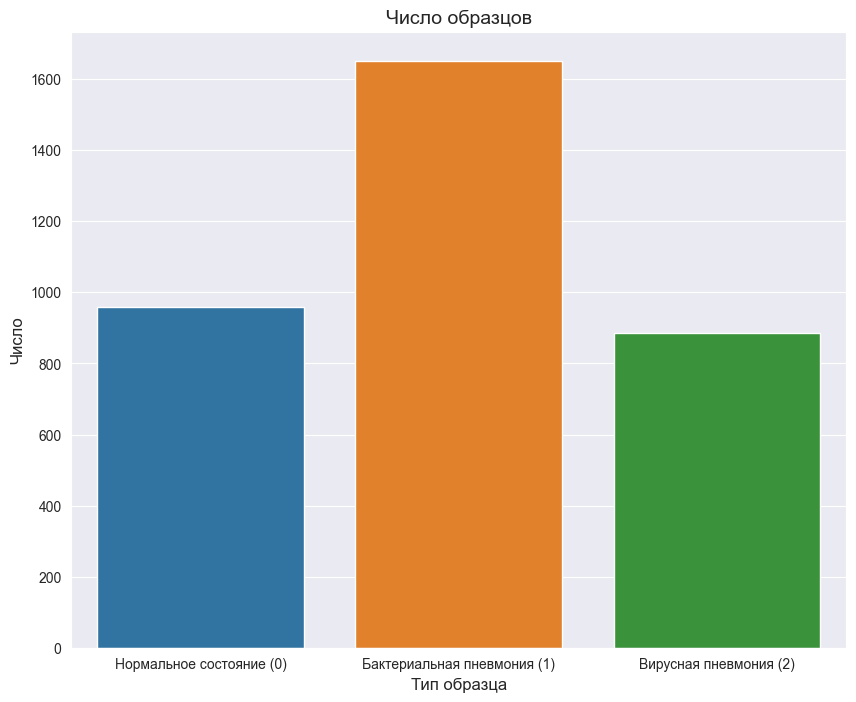

In [9]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10, 8))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Число образцов', fontsize=14)
plt.xlabel('Тип образца', fontsize=12)
plt.ylabel('Число', fontsize=12)
plt.xticks(range(len(cases_count.index)),
           ['Нормальное состояние (0)', 'Бактериальная пневмония (1)', 'Вирусная пневмония (2)'])
plt.show()

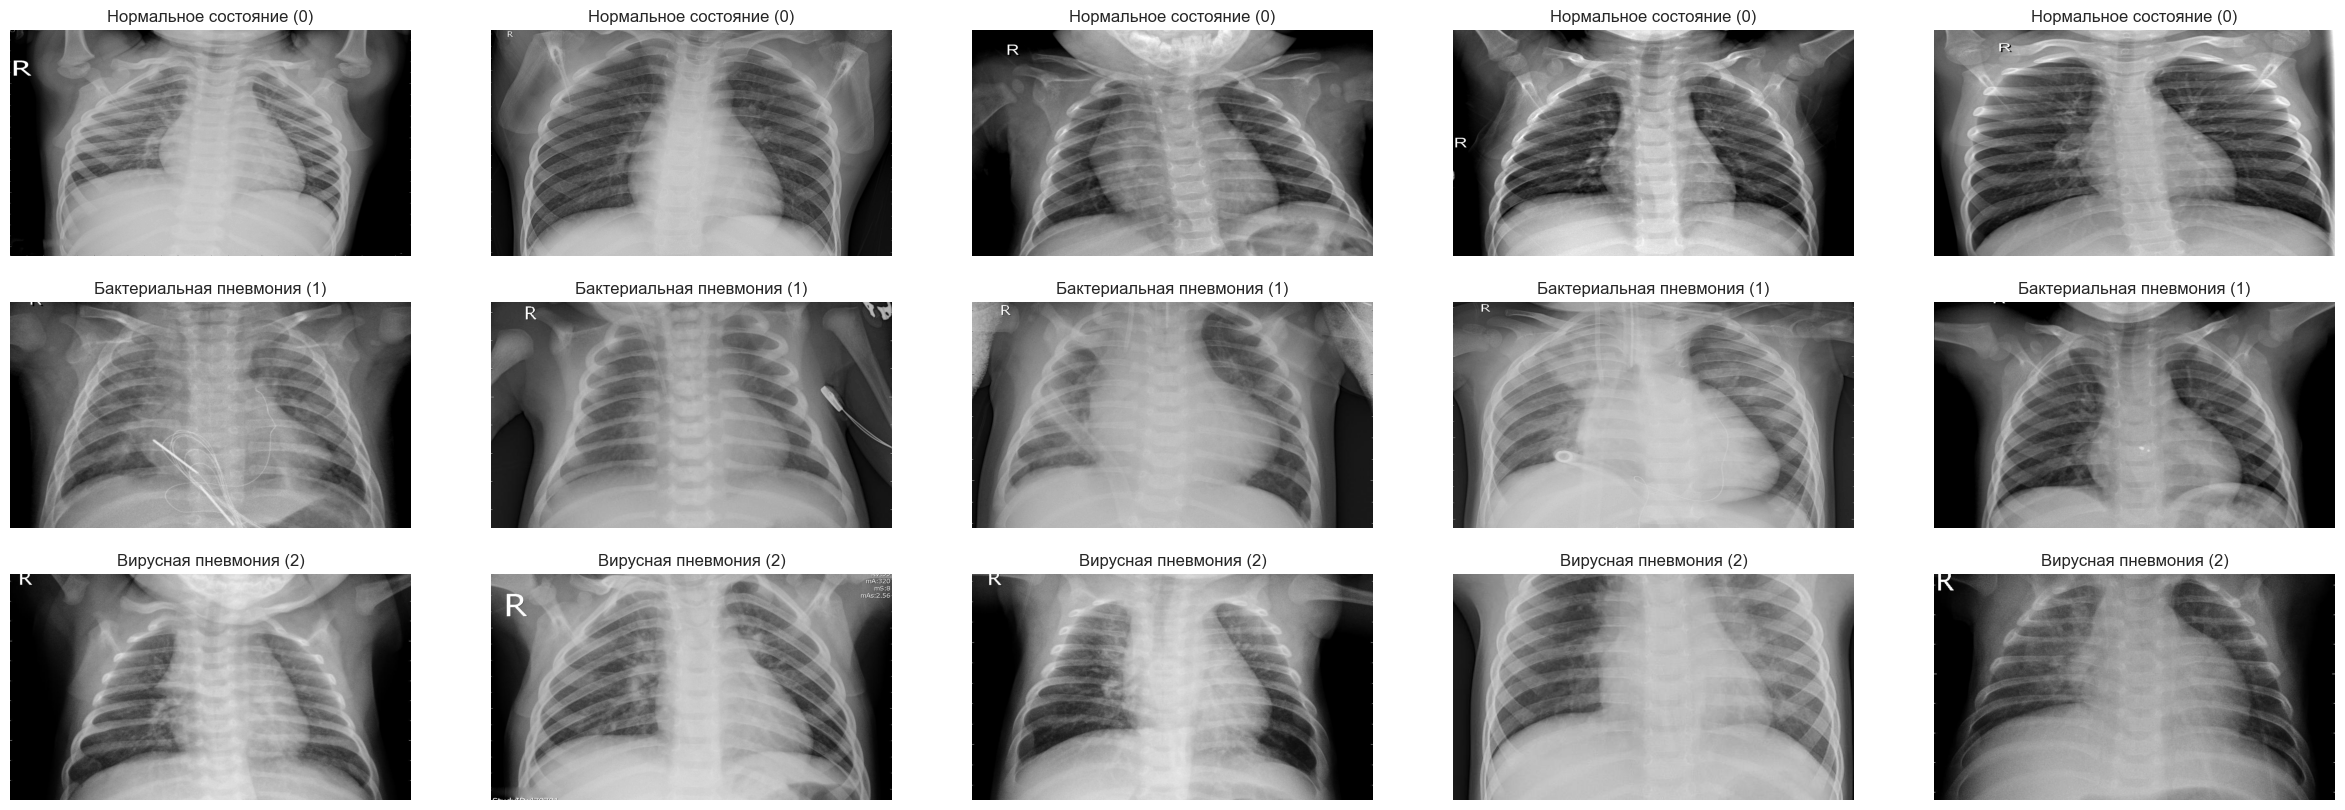

In [10]:
# Get few samples for both the classes
normal_samples = (train_data[train_data['label'] == 0]['image'].iloc[:5]).tolist()
bacteria_samples = (train_data[train_data['label'] == 1]['image'].iloc[:5]).tolist()
viral_samples = (train_data[train_data['label'] == 2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above three list
samples = normal_samples + bacteria_samples + viral_samples
del bacteria_samples, normal_samples, viral_samples

# Plot the data 
f, ax = plt.subplots(3, 5, figsize=(30, 10))
for i in range(15):
    img = imread(samples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')

    if i < 5:
        ax[i // 5, i % 5].set_title("Нормальное состояние (0)")
    elif 5 <= i < 10:
        ax[i // 5, i % 5].set_title("Бактериальная пневмония (1)")
    else:
        ax[i // 5, i % 5].set_title("Вирусная пневмония (2)")

    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')
plt.show()

# Parts of cGAN

In [12]:
print(generator_in_channels, discriminator_in_channels)

131 6


In [13]:
Discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 6)]     0         
                                                                 
 Conv2d_1 (Conv2D)           (None, 112, 112, 32)      1760      
                                                                 
 Batch_1 (BatchNormalization  (None, 112, 112, 32)     128       
 )                                                               
                                                                 
 Conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 Batch_2 (BatchNormalization  (None, 56, 56, 64)       256       
 )                                                               
                                                                 
 Conv2d_3 (Conv2D)           (None, 28, 28, 64)      

In [14]:
Generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NoiseInput (InputLayer)     [(None, 131)]             0         
                                                                 
 fc_1 (Dense)                (None, 25676)             3389232   
                                                                 
 reshape (Reshape)           (None, 14, 14, 131)       0         
                                                                 
 Batch_1 (BatchNormalization  (None, 14, 14, 131)      524       
 )                                                               
                                                                 
 Conv2DTrans_1 (Conv2DTransp  (None, 28, 28, 32)       67104     
 ose)                                                            
                                                                 
 Batch_2 (BatchNormalization  (None, 28, 28, 32)       12

# Fit

In [15]:
# Get a train data generator
dataset = data_gen(data=train_data, batch_size=batch_size, aug=Aug, add_labels=add_labels)

# Define the number of training steps
nb_train_steps = 0
for i in range(3):
    nb_train_steps += (add_labels[i] + 1) * cases_count[i]

nb_epochs = 300
nb_train_steps //= batch_size

print("Number of training and validation steps: {}".format(nb_train_steps))

NameError: name 'data_gen' is not defined

In [ ]:
Discriminator = keras.models.load_model(path_to_discriminator)
Generator = keras.models.load_model(path_to_generator)

In [ ]:
cond_gan = ConditionalGAN(discriminator=Discriminator, generator=Generator, latent_dim=latent_dim)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)

data = tf.data.Dataset.from_generator(
    lambda: data_gen(data=train_data, batch_size=batch_size, aug=Aug, add_labels=add_labels),
    output_types=(tf.float32, tf.float32),
    output_shapes=((batch_size, 224, 224, 3), (batch_size, 3))
)

In [ ]:
history_cGAN = cond_gan.fit(data, epochs=nb_epochs, steps_per_epoch=nb_train_steps, callbacks=[CustomCallback()])

In [ ]:
loss_g = history_cGAN.history["g_loss"]
loss_d = history_cGAN.history["d_loss"]
epochs = range(1, len(loss_g) + 1)
plt.plot(epochs, loss_g, "b", label="Потери на этапе обучения генератора")
plt.plot(epochs, loss_d, "g", label="Потери на этапе обучения дискриминатора")
plt.title("Потери на этапах обучения")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()

## Save GAN

In [ ]:
GAN = cond_gan.generator

In [ ]:
def interpolate(gen, inc, numbers):
    # Sample noise for the interpolation.
    interpolation_noise = tf.random.normal(shape=(numbers * len(inc), latent_dim))

    # One_hote coder
    repeats = [numbers, numbers, numbers]
    one_hot_labels = np.repeat(inc, repeats)
    one_hot_labels = keras.utils.to_categorical(one_hot_labels, num_classes)

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, one_hot_labels], 1)
    fake = gen.predict(noise_and_labels)
    return fake


examples = [0, 1, 2]
fake_images = interpolate(GAN, examples, 5)

In [ ]:
print(fake_images.shape)

# Plot the data 
f, ax = plt.subplots(3, 5, figsize=(30, 20))
for i in range(15):
    ax[i // 5, i % 5].imshow(fake_images[i], cmap='gray')

    if i < 5:
        ax[i // 5, i % 5].set_title("Normal")
    elif 5 <= i < 10:
        ax[i // 5, i % 5].set_title("Bacteria")
    else:
        ax[i // 5, i % 5].set_title("Viral")

    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')
plt.show()